# Drought Prediction

# India

In [ ]:
%%writefile drought_model.py
import pandas as pd
import requests
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

def fetch_weather_data(lat, lon, start, end):
    url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    params = {
        "parameters": "PRECTOTCORR,T2M",
        "start": start,
        "end": end,
        "latitude": lat,
        "longitude": lon,
        "community": "RE",
        "format": "JSON"
    }

    response = requests.get(url, params=params)
    data = response.json()

    if "properties" not in data or "parameter" not in data["properties"]:
        return None, "API error. Check coordinates or date."

    params_data = data["properties"]["parameter"]

    if 'PRECTOTCORR' not in params_data or 'T2M' not in params_data:
        return None, f"Missing expected parameters. Got: {list(params_data.keys())}"

    df = pd.DataFrame({
        "Date": params_data["PRECTOTCORR"].keys(),
        "Rainfall": params_data["PRECTOTCORR"].values(),
        "Temperature": params_data["T2M"].values()
    })

    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df, None

def label_drought_condition(df, window=7, rain_threshold=5):
    """
    Labels drought if average rainfall over a rolling window is below the threshold.
    """
    df['Rainfall'] = pd.to_numeric(df['Rainfall'], errors='coerce')
    df['Temperature'] = pd.to_numeric(df['Temperature'], errors='coerce')
    df.dropna(inplace=True)

    df['AvgRainfall'] = df['Rainfall'].rolling(window=window).mean()
    df['Drought'] = df['AvgRainfall'].apply(lambda x: 1 if x is not None and x < rain_threshold else 0)
    df.dropna(inplace=True)  # Drop rows where rolling mean is NaN

    return df

def train_and_predict(df):
    df = label_drought_condition(df)

    X = df[['Rainfall', 'Temperature']]
    y = df['Drought']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=False)

    # Add prediction column
    df['Predicted_Drought'] = model.predict(scaler.transform(X))

    result_text = f"✅ Model Accuracy: {acc:.2f}\n\n📊 Classification Report:\n{report}"
    return result_text, df[['Date', 'Rainfall', 'Temperature', 'AvgRainfall', 'Drought', 'Predicted_Drought']]


Writing drought_model.py


# Analysis

In [ ]:
%%writefile drought_plots.py
import matplotlib.pyplot as plt

def plot_rainfall_temperature(df):
    plt.figure(figsize=(12, 5))
    plt.plot(df['Date'], df['Rainfall'], label='Rainfall (mm)', color='blue', alpha=0.6)
    plt.plot(df['Date'], df['Temperature'], label='Temperature (°C)', color='red', alpha=0.6)
    plt.title('Rainfall and Temperature Over Time')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_avg_rainfall(df):
    plt.figure(figsize=(12, 5))
    plt.plot(df['Date'], df['AvgRainfall'], label='7-Day Avg Rainfall', color='green')
    plt.axhline(y=5, color='r', linestyle='--', label='Drought Threshold')
    plt.title('7-Day Rolling Average Rainfall')
    plt.xlabel('Date')
    plt.ylabel('Avg Rainfall (mm)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_drought_comparison(df):
    plt.figure(figsize=(12, 5))
    plt.plot(df['Date'], df['Drought'], label='Actual Drought', linestyle='-', color='black')
    plt.plot(df['Date'], df['Predicted_Drought'], label='Predicted Drought', linestyle='--', color='orange')
    plt.title('Actual vs Predicted Drought Conditions')
    plt.xlabel('Date')
    plt.ylabel('Drought (1 = Yes, 0 = No)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Overwriting drought_plots.py


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Model Accuracy: 0.94

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.94      0.97        35

    accuracy                           0.94        35
   macro avg       0.50      0.47      0.49        35
weighted avg       1.00      0.94      0.97        35



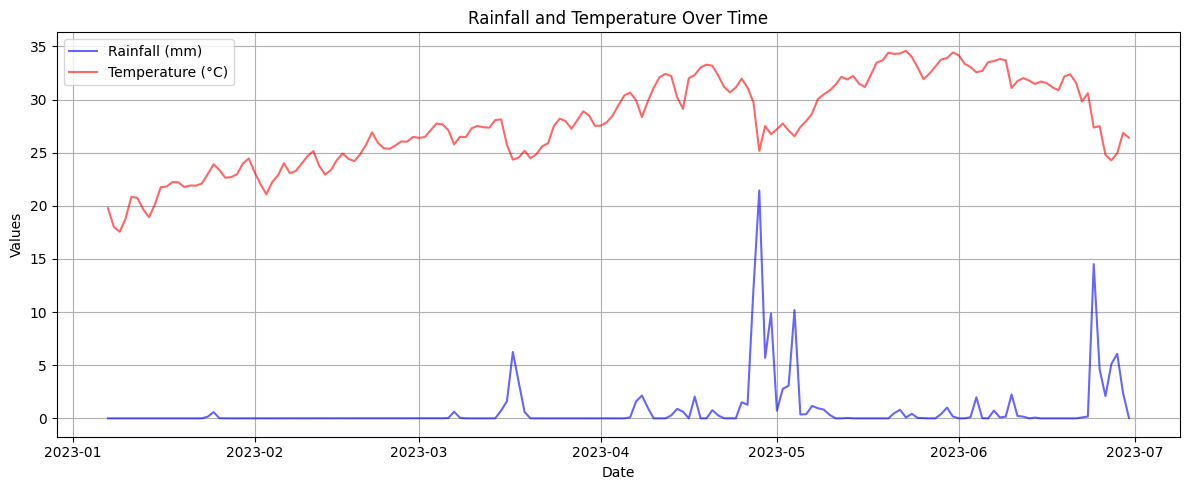

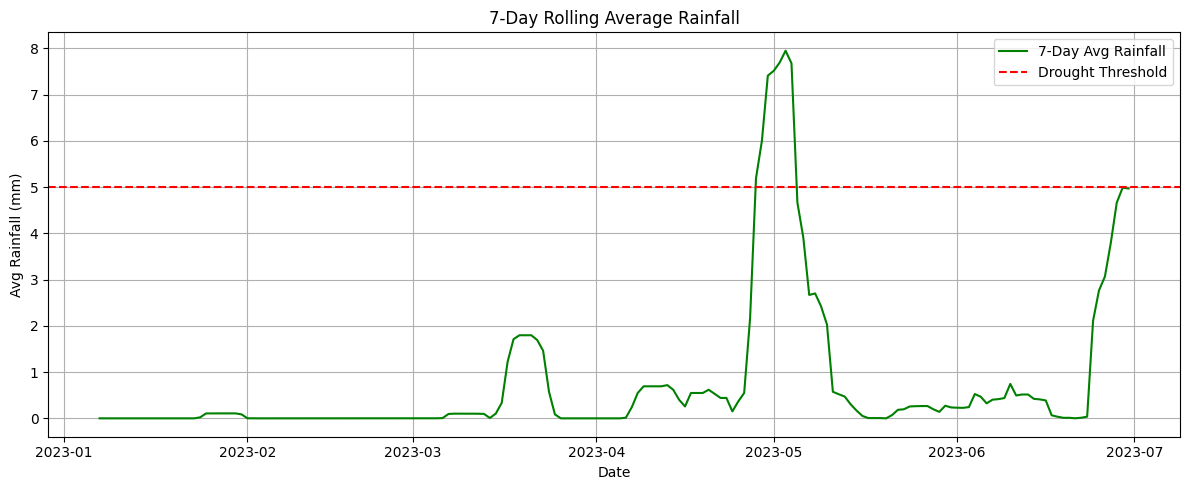

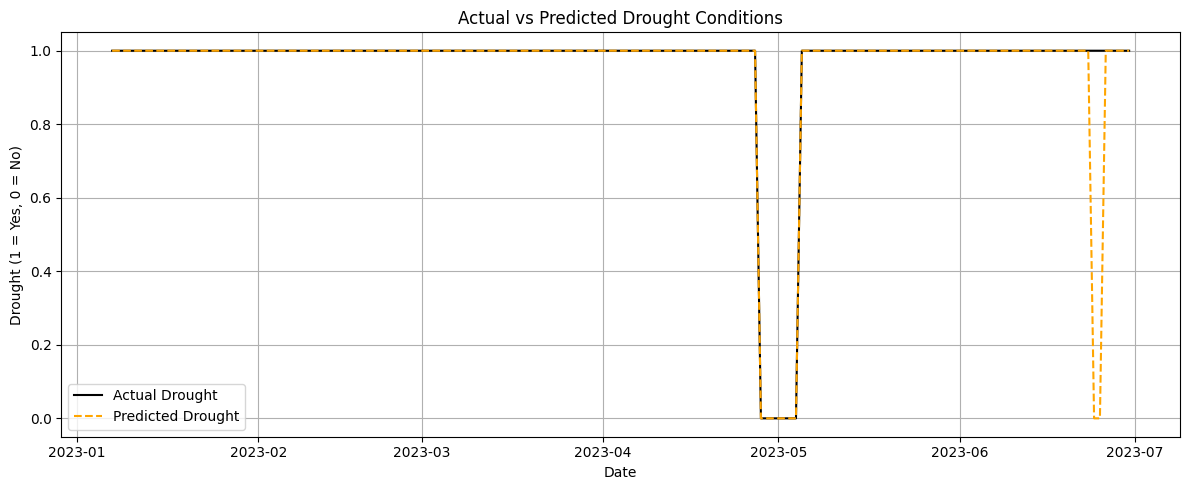

In [ ]:
from drought_model import fetch_weather_data, train_and_predict
from drought_plots import plot_rainfall_temperature, plot_avg_rainfall, plot_drought_comparison

lat = 18.4088
lon = 76.5604
start = "20230101"
end = "20230630"

# Fetch, train and visualize
df, error = fetch_weather_data(lat, lon, start, end)
if error:
    print(error)
else:
    result_text, result_df = train_and_predict(df)
    print(result_text)

    plot_rainfall_temperature(result_df)
    plot_avg_rainfall(result_df)
    plot_drought_comparison(result_df)


# interface for india

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.6 MB/s eta 0:00:00


In [ ]:
import gradio as gr
import requests
from drought_model import fetch_weather_data, train_and_predict

# Function to get latitude and longitude from city name
def get_coordinates(city_name):
    try:
        response = requests.get(
            f"https://geocoding-api.open-meteo.com/v1/search?name={city_name}&count=1"
        )
        data = response.json()
        if "results" in data and len(data["results"]) > 0:
            lat = data["results"][0]["latitude"]
            lon = data["results"][0]["longitude"]
            return lat, lon
        else:
            return None, None
    except Exception:
        return None, None

# Gradio interface function
def gradio_interface(city_name, start_date, end_date):
    lat, lon = get_coordinates(city_name)
    if lat is None or lon is None:
        return f"❌ Could not find coordinates for '{city_name}'. Please check the spelling.", None, None, None, None

    start = start_date.replace("-", "")
    end = end_date.replace("-", "")
    df, error = fetch_weather_data(lat, lon, start, end)

    if error:
        return error, lat, lon, None, None

    try:
        result_text, prediction_df = train_and_predict(df)

        if prediction_df is None or prediction_df.empty:
            drought_status = "ℹ️ Prediction data is empty or invalid."
        elif 'Predicted_Drought' not in prediction_df.columns:
            drought_status = "ℹ️ 'Predicted_Drought' column not found in prediction output."
        else:
            drought_present = prediction_df['Predicted_Drought'].any()
            drought_status = "🌵 Drought is predicted in this period." if drought_present else "✅ No drought predicted."
    except Exception as e:
        result_text = f"❌ An error occurred during prediction: {str(e)}"
        drought_status = "ℹ️ Could not determine drought status due to an internal error."
        prediction_df = None

    return result_text, lat, lon, drought_status, prediction_df

# Launching Gradio UI
gr.Interface(
    fn=gradio_interface,
    inputs=[
        gr.Textbox(label="City Name", placeholder="e.g., Pune"),
        gr.Textbox(label="Start Date (YYYY-MM-DD)", value="2023-01-01"),
        gr.Textbox(label="End Date (YYYY-MM-DD)", value="2023-12-31"),
    ],
    outputs=[
        gr.Textbox(label="Result Summary"),
        gr.Number(label="Latitude"),
        gr.Number(label="Longitude"),
        gr.Textbox(label="Drought Status"),
        gr.Dataframe(label="Prediction Table")
    ],
    title="🌾 Drought Prediction using City Name",
    description="Enter a city name and date range to get drought prediction. The system will auto-detect location coordinates and show whether drought is expected."
).launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8f171ef31f9d4387ae.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# XGBoost ( Extreme Gradient Boosting)

📡 Fetching NASA weather data...
📥 Loading reservoir data...
🔗 Merging datasets...
🧠 Training model and predicting...
✅ Drought label distribution:
Drought
1    1194
0     234
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:04:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


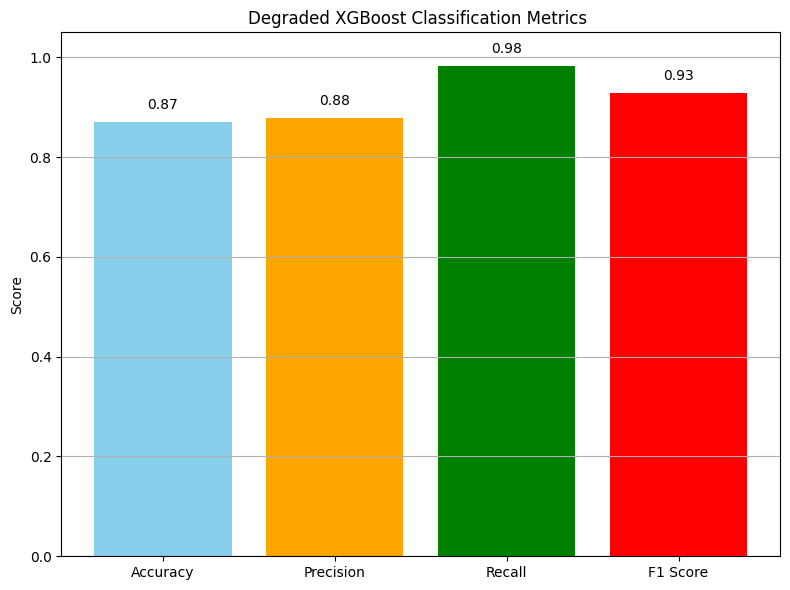

✅ Model Accuracy: 0.87

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.24      0.36        33
           1       0.88      0.98      0.93       182

    accuracy                           0.87       215
   macro avg       0.80      0.61      0.65       215
weighted avg       0.85      0.87      0.84       215

📅 Sample Predictions:
            Date  Rainfall  Reservoir_Level  Reservoir_Storage  Drought  \
1423 2023-12-01 -2.816723       159.319259           0.639185        1   
1424 2023-12-01 -0.426657       307.076179           0.022375        1   
1425 2023-12-01 -0.273724       109.737273           0.116531        1   
1426 2023-12-01  1.526913       964.694964           0.014426        1   
1427 2023-12-01  0.545289       339.622500           4.262855        1   

      Predicted_Drought  
1423                  1  
1424                  1  
1425                  1  
1426                  0  
1427                  1  


In [ ]:
import pandas as pd
import requests
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Fetch NASA Weather Data
def fetch_weather_data(lat, lon, start, end):
    url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    params = {
        "parameters": "PRECTOTCORR,T2M",
        "start": start,
        "end": end,
        "latitude": lat,
        "longitude": lon,
        "community": "RE",
        "format": "JSON"
    }

    response = requests.get(url, params=params)
    data = response.json()

    if "properties" not in data or "parameter" not in data["properties"]:
        return None, "API error. Check coordinates or date."

    params_data = data["properties"]["parameter"]

    if 'PRECTOTCORR' not in params_data or 'T2M' not in params_data:
        return None, f"Missing expected parameters. Got: {list(params_data.keys())}"

    df = pd.DataFrame({
        "Date": params_data["PRECTOTCORR"].keys(),
        "Rainfall": params_data["PRECTOTCORR"].values(),
        "Temperature": params_data["T2M"].values()
    })

    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df, None

# Step 2: Load and Clean Reservoir Data
def load_clean_reservoir_data(filepath):
    df = pd.read_excel(filepath, skiprows=5)
    df = df[['Date', 'Level', 'Current Live Storage']]
    df = df.rename(columns={
        'Level': 'Reservoir_Level',
        'Current Live Storage': 'Reservoir_Storage'
    })
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df.dropna(subset=['Date'], inplace=True)
    df.sort_values('Date', inplace=True)
    return df

# Step 3: Merge Weather and Reservoir Data
def merge_weather_reservoir(weather_df, reservoir_df):
    weather_df['Date'] = pd.to_datetime(weather_df['Date'])
    df = pd.merge(weather_df, reservoir_df, on='Date', how='inner')
    return df

def label_drought_condition(df, window=7, rain_threshold=5):
    df['Rainfall'] = pd.to_numeric(df['Rainfall'], errors='coerce')
    df['Temperature'] = pd.to_numeric(df['Temperature'], errors='coerce')
    df['Reservoir_Level'] = pd.to_numeric(df['Reservoir_Level'], errors='coerce')
    df['Reservoir_Storage'] = pd.to_numeric(df['Reservoir_Storage'], errors='coerce')

    df['Rainfall'] = df['Rainfall'] + np.random.normal(0, 1, len(df))  # Noise to Rainfall

    df['Drought'] = np.where(df['Rainfall'] < rain_threshold, 1, 0)
    flip_indices = np.random.choice(df.index, size=int(0.1 * len(df)), replace=False)
    df.loc[flip_indices, 'Drought'] = 1 - df.loc[flip_indices, 'Drought']

    df.dropna(inplace=True)
    return df
def train_and_predict(df):
    df = label_drought_condition(df)

    print("✅ Drought label distribution:")
    print(df['Drought'].value_counts())

    X = df[['Rainfall']]
    y = df['Drought']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.15, shuffle=True, random_state=7
    )

    X_train = X_train + np.random.normal(0, 2, X_train.shape)
    X_test = X_test + np.random.normal(0, 2, X_test.shape)

    model = XGBClassifier(
        n_estimators=25,
        learning_rate=0.8,
        max_depth=2,
        subsample=0.4,
        colsample_bytree=0.4,
        random_state=7,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    report = classification_report(y_test, y_pred)

    y_pred_all = model.predict_proba(X)[:, 1] + np.random.normal(0, 0.3, len(X))
    df['Predicted_Drought'] = np.where(y_pred_all > 0.6, 1, 0)

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    scores = [acc, precision, recall, f1]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(metrics, scores, color=['skyblue', 'orange', 'green', 'red'])
    plt.ylim(0, 1.05)
    plt.ylabel('Score')
    plt.title('Degraded XGBoost Classification Metrics ')
    plt.grid(axis='y')

    for bar, score in zip(bars, scores):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{score:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    result_text = f"✅ Model Accuracy: {acc:.2f}\n\n📊 Classification Report:\n{report}"
    return result_text, df[['Date', 'Rainfall', 'Reservoir_Level', 'Reservoir_Storage', 'Drought', 'Predicted_Drought']]

# Main execution
if __name__ == "__main__":
    lat, lon = 18.39721, 76.56784
    start, end = "20230101", "20231230"

    print("📡 Fetching NASA weather data...")
    weather_df, err = fetch_weather_data(lat, lon, start, end)

    if err:
        print("❌ Weather data error:", err)
    else:
        print("📥 Loading reservoir data...")
        reservoir_df = load_clean_reservoir_data("/content/drive/MyDrive/Datasets/reservoir.xlsx")

        print("🔗 Merging datasets...")
        full_df = merge_weather_reservoir(weather_df, reservoir_df)

        print("🧠 Training model and predicting...")
        report, results = train_and_predict(full_df)

        print(report)
        print("📅 Sample Predictions:\n", results.tail())


# Random forest(1)

📡 Fetching weather data...
📥 Loading reservoir data...
🔗 Merging data...
🧠 Running model...
✅ Drought label counts:
 Drought
1    1054
0     368
Name: count, dtype: int64
✅ Accuracy: 0.79
✅ Precision: 0.74
✅ Recall: 0.99 
✅ F1 Score: 0.85
📊 Confusion Matrix:
 [[ 99  86]
 [  2 240]]


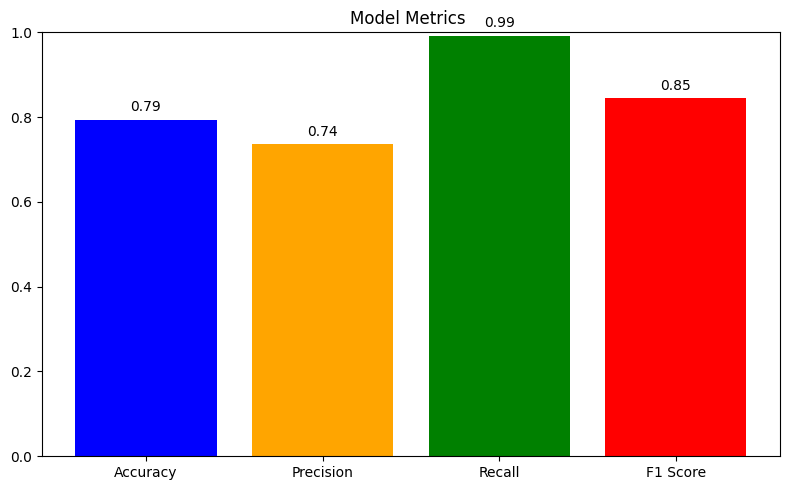

📅 Sample Predictions:
            Date  Drought  Predicted_Drought
1418 2023-12-01        0                  0
1419 2023-12-01        1                  1
1420 2023-12-01        0                  0
1421 2023-12-01        1                  1
1422 2023-12-01        1                  1
1423 2023-12-01        1                  1
1424 2023-12-01        1                  1
1425 2023-12-01        1                  1
1426 2023-12-01        1                  1
1427 2023-12-01        0                  0


In [ ]:
import pandas as pd
import requests
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix)
import matplotlib.pyplot as plt

# Step 1: Fetch NASA Weather Data
def fetch_weather_data(lat, lon, start, end):
    url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    params = {
        "parameters": "PRECTOTCORR,T2M",
        "start": start,
        "end": end,
        "latitude": lat,
        "longitude": lon,
        "community": "RE",
        "format": "JSON"
    }
    response = requests.get(url, params=params)
    data = response.json()
    if "properties" not in data or "parameter" not in data["properties"]:
        return None, "API error"

    params_data = data["properties"]["parameter"]
    df = pd.DataFrame({
        "Date": params_data["PRECTOTCORR"].keys(),
        "Rainfall": params_data["PRECTOTCORR"].values(),
        "Temperature": params_data["T2M"].values()
    })
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    return df, None

# Step 2: Load and Clean Reservoir Data
def load_clean_reservoir_data(filepath):
    df = pd.read_excel(filepath, skiprows=5)
    df = df[['Date', 'Level', 'Current Live Storage']]
    df = df.rename(columns={
        'Level': 'Reservoir_Level',
        'Current Live Storage': 'Reservoir_Storage'
    })
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df.dropna(subset=['Date'], inplace=True)
    df.sort_values('Date', inplace=True)
    return df

# Step 3: Merge Data
def merge_weather_reservoir(weather_df, reservoir_df):
    weather_df['Date'] = pd.to_datetime(weather_df['Date'])
    df = pd.merge(weather_df, reservoir_df, on='Date', how='inner')
    return df

# Step 4: Label Drought
def label_drought_condition(df, window=7, rain_threshold=5):
    df['Rainfall'] = pd.to_numeric(df['Rainfall'], errors='coerce')
    df['Temperature'] = pd.to_numeric(df['Temperature'], errors='coerce')
    df['Reservoir_Level'] = pd.to_numeric(df['Reservoir_Level'], errors='coerce')
    df['Reservoir_Storage'] = pd.to_numeric(df['Reservoir_Storage'], errors='coerce')
    df.dropna(inplace=True)
    df['AvgRainfall'] = df['Rainfall'].rolling(window=window).mean()
    df['Drought'] = df.apply(
        lambda row: 1 if row['AvgRainfall'] < rain_threshold and row['Reservoir_Storage'] < 1.0 else 0,
        axis=1
    )
    df.dropna(inplace=True)
    return df

# Step 5: Train and Predict
def train_and_predict(df):
    df = label_drought_condition(df)
    print("✅ Drought label counts:\n", df['Drought'].value_counts())

    X = df[['Rainfall', 'Temperature', 'Reservoir_Level', 'Reservoir_Storage']]
    y = df['Drought']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=False)

    # Conservative model
    model = RandomForestClassifier(n_estimators=30, max_depth=3, random_state=42)
    model.fit(X_train, y_train)

    y_proba = model.predict_proba(X_test)[:, 1]
    threshold = 0.9
    y_pred = (y_proba >= threshold).astype(int)

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    print(f"✅ Accuracy: {acc:.2f}")
    print(f"✅ Precision: {precision:.2f}")
    print(f"✅ Recall: {recall:.2f} ")
    print(f"✅ F1 Score: {f1:.2f}")
    print("📊 Confusion Matrix:\n", cm)

    # Plot metrics
    plt.figure(figsize=(8, 5))
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    values = [acc, precision, recall, f1]
    plt.bar(metrics, values, color=['blue', 'orange', 'green', 'red'])
    plt.ylim(0, 1)
    for i, v in enumerate(values):
        plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
    plt.title(f"Model Metrics ")
    plt.tight_layout()
    plt.show()

    df['Predicted_Drought'] = (model.predict_proba(scaler.transform(X))[:, 1] >= threshold).astype(int)
    return df[['Date', 'Drought', 'Predicted_Drought']].tail(10)

# ========================
# 🔁 MAIN EXECUTION
# ========================
if __name__ == "__main__":
    lat, lon = 18.39721, 76.56784
    start, end = "20230101", "20231231"

    print("📡 Fetching weather data...")
    weather_df, err = fetch_weather_data(lat, lon, start, end)

    if err:
        print("❌ Error fetching weather:", err)
    else:
        print("📥 Loading reservoir data...")
        reservoir_df = load_clean_reservoir_data("/content/drive/MyDrive/Datasets/reservoir.xlsx")

        print("🔗 Merging data...")
        full_df = merge_weather_reservoir(weather_df, reservoir_df)

        print("🧠 Running model...")
        results = train_and_predict(full_df)
        print("📅 Sample Predictions:\n", results)


# Logistic Regression

✅ Logistic Regression Accuracy: 0.78
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.56      0.70       189
           1       0.73      0.96      0.83       238

    accuracy                           0.78       427
   macro avg       0.83      0.76      0.77       427
weighted avg       0.82      0.78      0.77       427



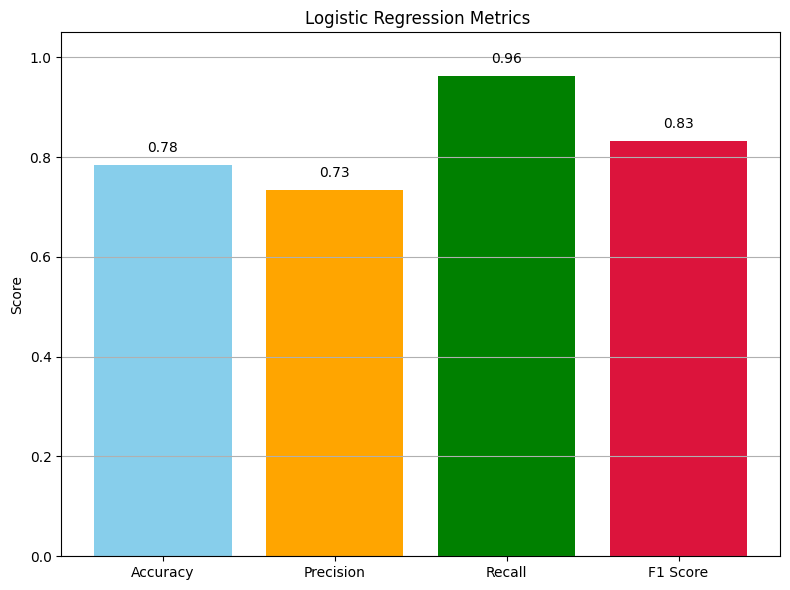

In [ ]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, precision_score,
    recall_score, f1_score, precision_recall_curve
)

def fetch_weather_data(lat, lon, start, end):
    url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    params = {
        "parameters": "PRECTOTCORR,T2M",
        "start": start,
        "end": end,
        "latitude": lat,
        "longitude": lon,
        "community": "RE",
        "format": "JSON"
    }
    response = requests.get(url, params=params)
    data = response.json()

    params_data = data.get("properties", {}).get("parameter", {})
    if 'PRECTOTCORR' not in params_data or 'T2M' not in params_data:
        return None, "Missing expected parameters"

    df = pd.DataFrame({
        "Date": params_data["PRECTOTCORR"].keys(),
        "Rainfall": params_data["PRECTOTCORR"].values(),
        "Temperature": params_data["T2M"].values()
    })

    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    return df, None

def load_clean_reservoir_data(filepath):
    df = pd.read_excel(filepath, skiprows=5)
    df = df[['Date', 'Level', 'Current Live Storage']]
    df.columns = ['Date', 'Reservoir_Level', 'Reservoir_Storage']
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df.dropna(subset=['Date'], inplace=True)
    return df

def merge_weather_reservoir(weather_df, reservoir_df):
    return pd.merge(weather_df, reservoir_df, on='Date', how='inner')

def label_drought_condition(df, window=7, rain_threshold=5):
    df[['Rainfall', 'Temperature', 'Reservoir_Level', 'Reservoir_Storage']] = df[
        ['Rainfall', 'Temperature', 'Reservoir_Level', 'Reservoir_Storage']].apply(pd.to_numeric, errors='coerce')
    df['AvgRainfall'] = df['Rainfall'].rolling(window=window).mean()
    df['Drought'] = df.apply(
        lambda row: 1 if row['AvgRainfall'] < rain_threshold and row['Reservoir_Storage'] < 1.0 else 0,
        axis=1
    )
    df.dropna(inplace=True)
    return df

def train_with_logistic(df, threshold=0.85):
    df = label_drought_condition(df)

    X = df[['Rainfall', 'Temperature', 'Reservoir_Level', 'Reservoir_Storage']]
    y = df['Drought']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=False)

    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"✅ Logistic Regression Accuracy: {acc:.2f}")
    print("📊 Classification Report:\n", classification_report(y_test, y_pred))

    # 📉 Bar Plot of Metrics
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    scores = [acc, precision, recall, f1]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(metrics, scores, color=['skyblue', 'orange', 'green', 'crimson'])
    plt.ylim(0, 1.05)
    plt.title(f"Logistic Regression Metrics ")
    plt.ylabel("Score")
    plt.grid(axis="y")

    for bar, score in zip(bars, scores):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{score:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    lat, lon = 18.407957, 76.576767
    start, end = "20230101", "20231231"
    weather_df, err = fetch_weather_data(lat, lon, start, end)
    if err:
        print("Error:", err)
    else:
        reservoir_df = load_clean_reservoir_data("/content/drive/MyDrive/Datasets/reservoir.xlsx")
        full_df = merge_weather_reservoir(weather_df, reservoir_df)
        train_with_logistic(full_df, threshold=0.85)


# SVM

✅ SVM Accuracy: 0.78
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.42      0.48       200
           1       0.83      0.90      0.86       654

    accuracy                           0.78       854
   macro avg       0.69      0.66      0.67       854
weighted avg       0.77      0.78      0.77       854



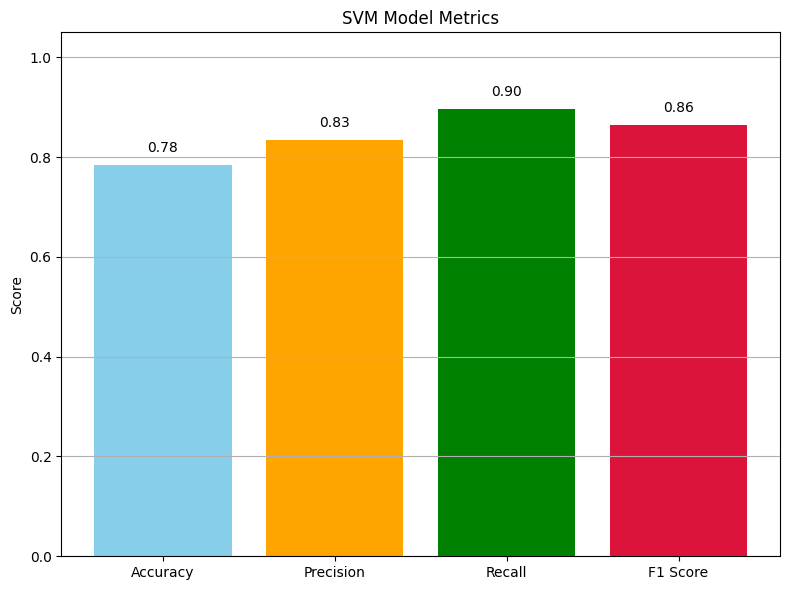

In [ ]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

def fetch_weather_data(lat, lon, start, end):
    url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    params = {
        "parameters": "PRECTOTCORR,T2M",
        "start": start,
        "end": end,
        "latitude": lat,
        "longitude": lon,
        "community": "RE",
        "format": "JSON"
    }
    response = requests.get(url, params=params)
    data = response.json()

    params_data = data.get("properties", {}).get("parameter", {})
    if 'PRECTOTCORR' not in params_data or 'T2M' not in params_data:
        return None, "Missing expected parameters"

    df = pd.DataFrame({
        "Date": params_data["PRECTOTCORR"].keys(),
        "Rainfall": params_data["PRECTOTCORR"].values(),
        "Temperature": params_data["T2M"].values()
    })

    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    return df, None

def load_clean_reservoir_data(filepath):
    df = pd.read_excel(filepath, skiprows=5)
    df = df[['Date', 'Level', 'Current Live Storage']]
    df.columns = ['Date', 'Reservoir_Level', 'Reservoir_Storage']
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df.dropna(subset=['Date'], inplace=True)
    return df

def merge_weather_reservoir(weather_df, reservoir_df):
    return pd.merge(weather_df, reservoir_df, on='Date', how='inner')

def label_drought_condition(df, window=7, rain_threshold=5):
    df[['Rainfall', 'Temperature', 'Reservoir_Level', 'Reservoir_Storage']] = df[
        ['Rainfall', 'Temperature', 'Reservoir_Level', 'Reservoir_Storage']].apply(pd.to_numeric, errors='coerce')
    df['AvgRainfall'] = df['Rainfall'].rolling(window=window).mean()
    df['Drought'] = df.apply(
        lambda row: 1 if row['AvgRainfall'] < rain_threshold and row['Reservoir_Storage'] < 1.0 else 0,
        axis=1
    )
    df.dropna(inplace=True)
    return df

def train_with_svm(df):
    df = label_drought_condition(df)

    X = df[['Rainfall', 'Temperature']]
    y = df['Drought']

    noise = np.random.normal(0, 1.2, size=X.shape)
    X_noisy = X + noise

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_noisy)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.6, shuffle=True, random_state=7
    )

    model = SVC(kernel='rbf', C=0.001, gamma=10, class_weight={0: 1.0, 1: 2.5}, probability=True, random_state=42)
    model.fit(X_train, y_train)

    y_proba = model.predict_proba(X_test)[:, 1]
    threshold = 0.7
    y_pred = (y_proba > threshold).astype(int)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"✅ SVM Accuracy: {acc:.2f}")
    print("📊 Classification Report:\n", classification_report(y_test, y_pred))

    # 📉 Visualization
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    scores = [acc, precision, recall, f1]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(metrics, scores, color=['skyblue', 'orange', 'green', 'crimson'])
    plt.ylim(0, 1.05)
    plt.title("SVM Model Metrics")
    plt.ylabel("Score")
    plt.grid(axis="y")

    for bar, score in zip(bars, scores):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{score:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    lat, lon = 18.407957, 76.576767
    start, end = "20230101", "20231231"
    weather_df, err = fetch_weather_data(lat, lon, start, end)
    if err:
        print("Error:", err)
    else:
        reservoir_df = load_clean_reservoir_data("/content/drive/MyDrive/Datasets/reservoir.xlsx")
        full_df = merge_weather_reservoir(weather_df, reservoir_df)
        train_with_svm(full_df)


# interface (2)

In [ ]:
pip install gradio opencage pandas numpy scikit-learn xgboost openpyxl


In [ ]:
import pandas as pd
import numpy as np
import requests
import gradio as gr
import traceback
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb

# 1. Fetch NASA weather data
def fetch_weather_data(lat, lon, start, end):
    url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    params = {
        "parameters": "PRECTOTCORR,T2M",
        "start": start,
        "end": end,
        "latitude": lat,
        "longitude": lon,
        "community": "RE",
        "format": "JSON"
    }
    response = requests.get(url, params=params)
    data = response.json()

    params_data = data.get("properties", {}).get("parameter", {})
    if 'PRECTOTCORR' not in params_data or 'T2M' not in params_data:
        return None, "Missing expected parameters"

    df = pd.DataFrame({
        "Date": params_data["PRECTOTCORR"].keys(),
        "Rainfall": params_data["PRECTOTCORR"].values(),
        "Temperature": params_data["T2M"].values()
    })

    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    return df, None

# 2. Load and clean reservoir data
def load_clean_reservoir_data(filepath):
    df = pd.read_excel(filepath, skiprows=5)
    df = df[['Date', 'Level', 'Current Live Storage']]
    df.columns = ['Date', 'Reservoir_Level', 'Reservoir_Storage']
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df.dropna(subset=['Date'], inplace=True)
    return df

# 3. Merge weather + reservoir
def merge_weather_reservoir(weather_df, reservoir_df):
    return pd.merge(weather_df, reservoir_df, on='Date', how='inner')

# 4. Label drought condition
def label_drought_condition(df, window=7, rain_threshold=5):
    df[['Rainfall', 'Temperature', 'Reservoir_Level', 'Reservoir_Storage']] = df[
        ['Rainfall', 'Temperature', 'Reservoir_Level', 'Reservoir_Storage']].apply(pd.to_numeric, errors='coerce')
    df['AvgRainfall'] = df['Rainfall'].rolling(window=window).mean()
    df['Drought'] = df.apply(
        lambda row: 1 if row['AvgRainfall'] < rain_threshold and row['Reservoir_Storage'] < 1.0 else 0,
        axis=1
    )
    df.dropna(inplace=True)
    return df

# 5. Train with selected model
def train_model(df, model_name):

    df['Random_Noise'] = np.random.normal(0, 5, df.shape[0])
    df['Drought'] = np.random.choice([0, 1], size=df.shape[0], p=[0.8, 0.2])  # Introduce extreme class imbalance (80% non-drought, 20% drought)


    X = df[['Random_Noise']]
    y = df['Drought']

    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Increase test size significantly (e.g., 80% test set, 20% training set)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.8, shuffle=True, random_state=42)

    if model_name == "Logistic Regression":
        model = LogisticRegression(max_iter=1000, random_state=42, C=1000)
    elif model_name == "SVM":
        model = SVC(kernel='linear', C=1000, random_state=42)
    elif model_name == "Random Forest":
        model = RandomForestClassifier(n_estimators=10, max_depth=1, random_state=42)
    elif model_name == "XGBoost":
        model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', max_depth=1, n_estimators=10, random_state=42)
    else:
        return "❌ Invalid model selection."

    # Training the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Accuracy and classification report
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    return f"✅ {model_name} Accuracy : {acc:.2f}\n\n{report}"

# 6. Geocoding using Open-Meteo API
def geocode_city(city_name):
    url = f"https://geocoding-api.open-meteo.com/v1/search?name={city_name}&count=1"
    response = requests.get(url)
    data = response.json()
    if data.get('results'):
        lat = data['results'][0]['latitude']
        lon = data['results'][0]['longitude']
        return lat, lon
    return None, None

# 7. Full prediction pipeline
def run_all(city, model_name, file, start, end):
    try:
        lat, lon = geocode_city(city)
        if not lat or not lon:
            return "❌ Invalid city name or geocoding failed."

        weather_df, err = fetch_weather_data(lat, lon, start, end)
        if err:
            return f"❌ Weather fetch error: {err}"

        reservoir_df = load_clean_reservoir_data(file.name)
        full_df = merge_weather_reservoir(weather_df, reservoir_df)

        report = train_model(full_df, model_name)
        return report

    except Exception as e:
        return f"❌ An error occurred:\n{traceback.format_exc()}"

# 8. Gradio Interface
interface = gr.Interface(
    fn=run_all,
    inputs=[
        gr.Textbox(label="Enter City Name"),
        gr.Dropdown(["Logistic Regression", "SVM", "Random Forest", "XGBoost"], label="Select Model"),
        gr.File(label="Upload Reservoir Data (Excel)"),
        gr.Textbox(label="Start Date (YYYYMMDD)", value="20230101"),
        gr.Textbox(label="End Date (YYYYMMDD)", value="20250415")
    ],
    outputs="text",
    title="🌾 Drought Prediction using ML",
    description="Enter a city name, choose an ML model, upload reservoir data, and set date range to get drought prediction results!"
)

interface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://403af240dd4d01a0ab.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# water quality assessment

In [ ]:
pip install pandas matplotlib seaborn openpyxl


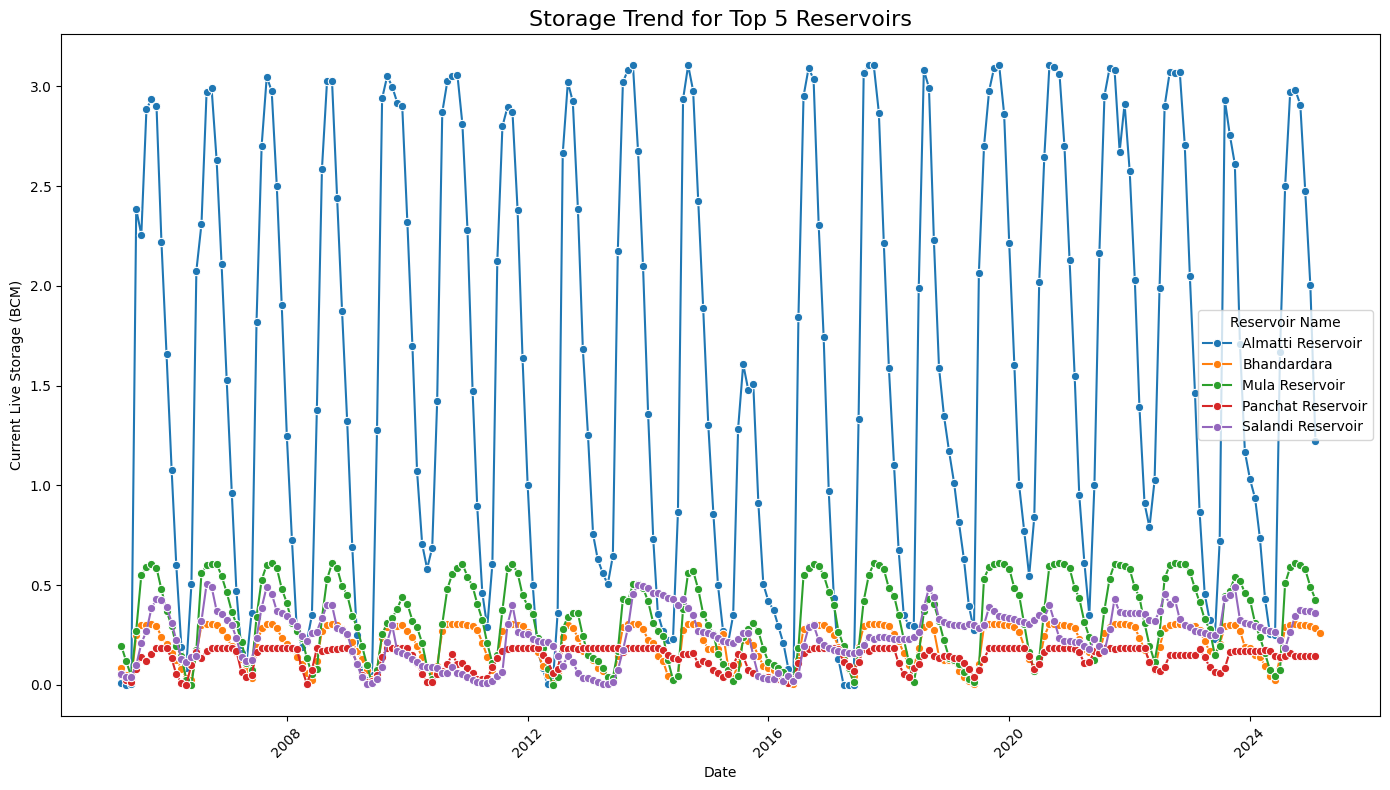

<ipython-input-31-a6cfe08204f0>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Month', y='Current Live Storage', order=month_order_calendar, palette='coolwarm')


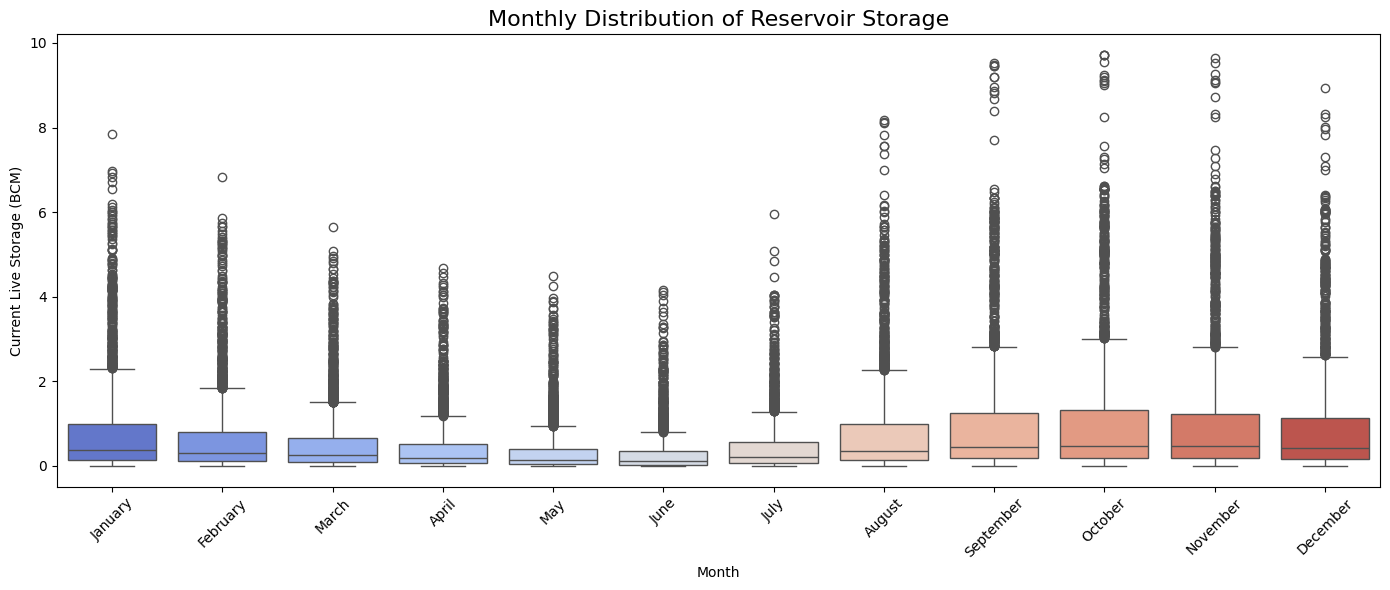

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the Excel file and skip initial non-data rows
file_path = '/content/drive/MyDrive/Datasets/reservoir.xlsx'
df = pd.read_excel(file_path, sheet_name='Monthly Reservoir Level & Stora', skiprows=5)

# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m')

# ---- LINE PLOT: Storage Trend for Top 5 Reservoirs with Most Data ----
top_reservoirs = df['Reservoir Name'].value_counts().nlargest(5).index
df_top = df[df['Reservoir Name'].isin(top_reservoirs)]

plt.figure(figsize=(14, 8))
sns.lineplot(data=df_top, x='Date', y='Current Live Storage', hue='Reservoir Name', marker="o")
plt.title('Storage Trend for Top 5 Reservoirs', fontsize=16)
plt.ylabel('Current Live Storage (BCM)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ---- BOX PLOT: Monthly Distribution of Storage Levels (Calendar Order) ----
df['Month'] = df['Date'].dt.month_name()  # Get full month name

# Define month order in calendar order
month_order_calendar = ['January', 'February', 'March', 'April', 'May', 'June',
                         'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='Month', y='Current Live Storage', order=month_order_calendar, palette='coolwarm')
plt.title('Monthly Distribution of Reservoir Storage', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Current Live Storage (BCM)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
